### Generate Dataset for a simple 3DoF

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
# Define Hyper-parameters
arm_num             = 3
arm_lengths         = [0.5, 0.5, 1]
arm_max_length      = np.sum(arm_lengths)
num_samples         = 10000
sample_vars         = [1/16, 1/4, 1/4, 1/4]
eps                 = 0.2

In [21]:
# Define utilities

def determine_final_position(origin_pos, arm_angles, arm_lengths=arm_lengths, evaluate_mode=True):

    positions = []
    current_pos = np.zeros([len(origin_pos), 2])
    print("shape of current_pos = ", np.shape(current_pos))
    current_pos[:, 0] = 0
    current_pos[:, 1] = origin_pos
    positions.append(np.copy(current_pos))

    arm_angles_diff = np.copy(arm_angles)
    arm_angles_diff[:, 1] -= arm_angles[:, 0]
    arm_angles_diff[:, 2] -= arm_angles[:, 1] + arm_angles[:, 0]

    for arm_index in range(arm_num):
        current_pos[:, 0] += np.cos(arm_angles_diff[:, arm_index]) * arm_lengths[arm_index]
        current_pos[:, 1] += np.sin(arm_angles_diff[:, arm_index]) * arm_lengths[arm_index]
        positions.append(np.copy(current_pos)) 

    if not evaluate_mode:
        plot_arms(np.array(positions))
    return current_pos, np.array(positions)



def plot_arms(positions, save_dir='.', save_name='robotic_arms_plot.png', margin=0.2):
    f = plt.figure()
    shape = np.shape(positions)
    plt.plot([0, 0], [-1.5, 1.5], lw=1, c='b')
    print("shape of positions", np.shape(positions))
    strange_list = np.arange(shape[1])[np.min(positions[:, :, 0], axis=0) < 0]
    #print("strange list is", strange_list)
    #print("position of those strange ones are", positions[:, strange_list, :])
    #print("DEBUG: ", positions[:, 0, 0].shape)
    for i in range(shape[1]):
        plt.plot(positions[:, i, 0], positions[:, i, 1], lw=1, ls='-', c='k', alpha=0.1)
        if i in strange_list:
            #print(i)
            plt.plot(positions[:, i, 0], positions[:, i, 1], lw=2, c='b', alpha=0.5)

    plt.plot()
    f.savefig(os.path.join(save_dir, save_name))



def sample_through_space():
    data_x = np.random.randn(num_samples, arm_num + 1)
    for i in range(len(data_x[0, :])):
        data_x[:, i] *= np.sqrt(sample_vars[i])
        #print(np.var(data_x[:, i]))
    # print("data_x", data_x)
    print("shape of data_x is:", np.shape(data_x))
    data_y, positions = determine_final_position(data_x[:, 0], data_x[:, 1:])
    # print("data_y", data_y)
    print("shape of data_y is", np.shape(data_y))
    print("shape of positions is:", np.shape(positions))
    # print("position=", positions)
    plot_arms(positions)
    np.savetxt('data_x.csv', data_x, delimiter=',')
    np.savetxt('data_y.csv', data_y, delimiter=',')

shape of data_x is: (10000, 4)
shape of current_pos =  (10000, 2)
shape of data_y is (10000, 2)
shape of positions is: (4, 10000, 2)
shape of positions (4, 10000, 2)


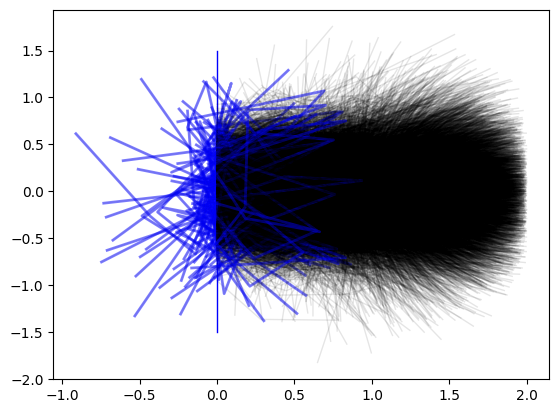

In [22]:
sample_through_space()

### Train/Eval INN

In [29]:
import glob
import os
import shutil
import torch
import pickle
import pandas as pd
import sys
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from copy import deepcopy


class SimulatedDataSet_regress(Dataset):
    """ The simulated Dataset Class for regression purposes"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, ind):
        return self.x[ind, :], self.y[ind,:]
     

def get_data_into_loaders(data_x, data_y, batch_size, DataSetClass, rand_seed=1234, test_ratio=0.05):
    """
    Helper function that takes structured data_x and data_y into dataloaders
    :param data_x: the structured x data
    :param data_y: the structured y data
    :param rand_seed: the random seed
    :param test_ratio: The testing ratio
    :return: train_loader, test_loader: The pytorch data loader file
    """
    # Normalize the input
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=test_ratio,
                                                        random_state=rand_seed)
    print('total number of training sample is {}, the dimension of the feature is {}'.format(len(x_train), len(x_train[0])))
    print('total number of test sample is {}'.format(len(y_test)))

    # Construct the dataset using a outside class
    train_data = DataSetClass(x_train, y_train)
    test_data = DataSetClass(x_test, y_test)

    # Construct train_loader and test_loader
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_loader, test_loader


def read_data_robotic_arm(flags, eval_data_all=False):
    """
    Data reader function for the robotic arm data set
    :param flags: Input flags
    :return: train_loader and test_loader in pytorch data set format (normalized)
    """
    data_x = pd.read_csv('data_x.csv', header=None).astype('float32').values
    data_y = pd.read_csv('data_y.csv', header=None).astype('float32').values
    if eval_data_all:
        return get_data_into_loaders(data_x, data_y, flags.batch_size, SimulatedDataSet_regress, test_ratio=0.999)
    return get_data_into_loaders(data_x, data_y, flags.batch_size, SimulatedDataSet_regress, test_ratio=flags.test_ratio)



def save_flags(flags, save_dir, save_file="flags.obj"):
    """
    This function serialize the flag object and save it for further retrieval during inference time
    :param flags: The flags object to save
    :param save_file: The place to save the file
    :return: None
    """
    with open(os.path.join(save_dir, save_file),'wb') as f:          # Open the file
        pickle.dump(flags, f)               # Use Pickle to serialize the object


def write_flags_and_BVE(flags, best_validation_loss, save_dir, forward_best_loss=None):
    """
    The function that is usually executed at the end of the training where the flags and the best validation loss are recorded
    They are put in the folder that called this function and save as "parameters.txt"
    This parameter.txt is also attached to the generated email
    :param flags: The flags struct containing all the parameters
    :param best_validation_loss: The best_validation_loss recorded in a training
    :param forard_best_loss: The forward best loss only applicable for Tandem model
    :return: None
    """
    flags.best_validation_loss = best_validation_loss  # Change the y range to be acceptable long string
    if forward_best_loss is not None:
        flags.best_forward_validation_loss = forward_best_loss
    # To avoid terrible looking shape of y_range
    yrange = flags.y_range
    # yrange_str = str(yrange[0]) + ' to ' + str(yrange[-1])
    yrange_str = [yrange[0], yrange[-1]]
    copy_flags = deepcopy(flags)
    copy_flags.y_range = yrange_str  # in order to not corrupt the original data strucutre
    flags_dict = vars(copy_flags)
    # Convert the dictionary into pandas data frame which is easier to handle with and write read
    with open(os.path.join(save_dir, 'parameters.txt'), 'w') as f:
        print(flags_dict, file=f)
    # Pickle the obj
    save_flags(flags, save_dir=save_dir)


def simulator_robotic(Xpred):
    """
    The simulator function for robotic arms, input arm angles output final position Y
    :param Xpred: The Xpred output from model
    :return:
    """
    Ypred, positions = determine_final_position(Xpred[:, 0], Xpred[:, 1:], evaluate_mode=True)
    return Ypred

def simulator(data_set, Xpred):
    """
    This is the simulator which takes Xpred from inference models and feed them into real data
    simulator to get Ypred
    :param data_set: str, the name of the data set
    :param Xpred: (N, dim_x), the numpy array of the Xpred got from the inference model
    :return: Ypred from the simulator
    """

    if data_set == 'robotic_arm':
        return simulator_robotic(Xpred)
    else:
        sys.exit("In Simulator: Your data_set entry is not correct, check again!")


class time_keeper(object):
    def __init__(self, time_keeping_file="time_keeper.txt", max_running_time=9999):
        self.start = time.time()
        self.max_running_time = max_running_time * 60 * 60
        self.time_keeping_file = time_keeping_file
        self.end = -1
        self.duration = -1

    def record(self, write_number):
        """
        Record the time to the time_keeping_file, the time marked is the interval between current time and the start time
        :param write_number:
        :return:
        """
        with open(self.time_keeping_file, "a") as f:
            self.end = time.time()
            self.duration = self.end - self.start
            f.write('{},{}\n'.format(write_number, self.duration))
            if (self.duration > self.max_running_time):
                raise ValueError('Your program has run over the maximum time limit set by Ben in time_keeper function')

In [26]:
# model maker
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom

import FrEIA.framework as Ff
import FrEIA.modules as Fm

def INN(flags):
    """
    The constructor for INN network
    :param flags: input flags from configuration
    :return: The INN network
    """
    # Start from input layer
    nodes = [Ff.InputNode(flags.dim_tot, name='input')]
    # Recursively add the coupling layers and random permutation layer
    for i in range(flags.couple_layer_num):
        nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                          {'subnet_constructor': subnet_fc,
                           'clamp': 2.0},
                          name='coupling_{}'.format(i)))
        nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {'seed': i}, name='permute_{}'.format(i)))
    # Attach the output Node
    nodes.append(Ff.OutputNode(nodes[-1], name='output'))
    print("The nodes are:", nodes)
    # Return the
    return Ff.ReversibleGraphNet(nodes, verbose=True)

##########
# Subnet #
##########

def subnet_fc(c_in, c_out):
    return torch.nn.Sequential(torch.nn.Linear(c_in, 512), 
                               torch.nn.ReLU(), 
                               torch.nn.Linear(512,512),
                               torch.nn.ReLU(),
                               torch.nn.Linear(512,  c_out))

In [ ]:
# Class wrapper for the network
import os
import time
import torch
import math
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def training_from_flag(flags):
    """
    Training interface. 1. Read data 2. initialize network 3. train network 4. record flags
    :param flag: The training flags read from command line or parameter.py
    :return: None
    """

    # Get the data
    train_loader, test_loader = read_data_robotic_arm(flags)

    # Build network
    print("Build the network ...")
    net = Network(INN, flags, train_loader, test_loader, ckpt_dir=flags.ckpt_dir)

    # Train network
    print("Start the training ...")
    net.train()

    # Save the parameters
    write_flags_and_BVE(flags, net.best_validation_loss, net.ckpt_dir)

